In [147]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  
le=WordNetLemmatizer()

from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gm # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\balam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [148]:
#Import the dataset
df = pd.read_csv("FullTweets.csv", encoding = "utf-8-sig", sep = ",")
df['is_retweet'] = df['is_retweet'].fillna(False)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         105000 non-null  object
 1   user_location     78321 non-null   object
 2   user_description  96038 non-null   object
 3   user_created      105000 non-null  object
 4   user_followers    105000 non-null  int64 
 5   user_friends      105000 non-null  int64 
 6   user_favourites   105000 non-null  int64 
 7   user_verified     105000 non-null  bool  
 8   date              105000 non-null  object
 9   text              105000 non-null  object
 10  hashtags          39311 non-null   object
 11  source            105000 non-null  object
 12  is_retweet        105000 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 9.0+ MB


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,needlenose5,"Milford, CT","Husband, dad to kids. Pro Trump. GPU head, Subject to Governor NeedleNose Ned Lamont",2020-03-25 21:23:13+00:00,12,86,1089,False,2022-03-07 23:59:59+00:00,"@MaryLTrump @DavidCornDC Agreed, why do people keep on supporting Democrats??? From the COVID-19 lies to the fake climate crisis to the fake Jan 6th insurrection to the fake inflation caused by greedy corporations to the …",NaN,Twitter for iPhone,False
1,workonline44,NaN,NaN,2016-07-30 03:40:00+00:00,30136,1915,62,False,2022-03-07 23:59:56+00:00,AD iHealth™ Covid-19 Antigen testing kits for sale https://t.co/4BMuYxmuH5,NaN,Twitter Web App,False
2,Uab_BabaKofi,"Virginia, USA","Dad of two daughters, husband, Consulting IT Specialist. #DemocracyIsInPeril #UniteBlue #ForThePeople \nCreating Harmony in All You Do is the \nUltimate BE-NESS",2016-03-05 21:10:37+00:00,9874,10842,41264,False,2022-03-07 23:59:54+00:00,Study links even mild Covid-19 to changes in the brain - CNN #DemForce https://t.co/diPFToBDv6,['DemForce'],Twitter for iPad,False
3,ActivistBowen2,Hong Kong,"AMERICAN EXPAT in HONG KONG, person, blogger, dissident, son, brother, friend NOT a 1-man show; FULLY VAXXED + BOOSTED #SCIENCE BETTER THAN DEATH #COVID",2011-06-08 20:17:01+00:00,4168,4997,5217,False,2022-03-07 23:59:36+00:00,",...a NON-#covid19 death ON TOP OF ALL the #covid19 deaths (March 7, 2022; 22:17 HKT) #HONGKONG #HK","['covid19', 'covid19', 'HONGKONG', 'HK']",Twitter Web App,False
4,RAChampion,Sydney Australia,"Digital Marketing, Brand Promotion & Social Media Planning. Top #SocialMedia News, Trends & Apps.",2012-06-12 12:28:09+00:00,2472,1519,4,False,2022-03-07 23:59:33+00:00,SFC urges Hong Kong businesses to update continuity plans as mass Covid-19 testing looms in the city https://t.co/bcx5kVFP3t,NaN,dlvr.it,False


In [149]:
#Use this to replace the contracted words
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [150]:
#The clean documents method removes URls, @mentions, hashtags, text in brackets
#Does twitter specific tokenization of the text and lemmatizes the text
#All text are converted to lower case
def clean_documents(text):
    
    if pd.isnull(text):
        return text
    
    text = text.lower()
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub('http[^\s]+','',text) #Remove URLs
    text = re.sub("@[A-Za-z0-9_]+","", text) #Remove @mentions
    text = re.sub("#[A-Za-z0-9_]+","", text) #Remove hashtags
    
    return text

In [189]:
#df['clean_text'] = df['text'].apply(lambda x: clean_documents(x))
pd.set_option('display.max_colwidth', 220)
df_temp = pd.DataFrame(columns = ['clean_text'])
df_temp['clean_text'] = df['clean_text']

df_temp.head(10)


,clean_text
0,"agreed, why do people keep on supporting democrats??? from the covid-19 lies to the fake climate crisis to the fake jan 6th insurrection to the fake inflation caused by greedy corporations to the …"
1,ad ihealth™ covid-19 antigen testing kits for sale
2,study links even mild covid-19 to changes in the brain - cnn
3,",...a non- death on top of all the deaths (march 7, 2022; 22:17 hkt)"
4,sfc urges hong kong businesses to update continuity plans as mass covid-19 testing looms in the city
5,you’ve taken a few too many hits on the crack pipe. our natural immunity works better than any vaccine. my whole family had covid 19- not hospitalized! we are healthy people. no vaccine required. god bless
6,a look at covid medical waste and how to handle it \n\n
7,"….information from the platforms about the major sources of covid-19 misinformation, including those that engaged in the sale of unproven covid-19 products, services and treatments.\n\n lol that would be you!"
8,uncontrolled spread of can lead to the creation of a worse variant.\n\nus seems to be setting up perfect conditions for a worse variant that won’t just harm our country but will harm the world.\n\nit’s shameful we w...
9,does anyone know if ihealth covid-19 antigen rapid tests from usps are approved for travel back to u.s.? I am getting conflicting answers online. technically the test should be acceptable when proctored online since ...


In [37]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_tweets = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_tweets, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_tweets.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

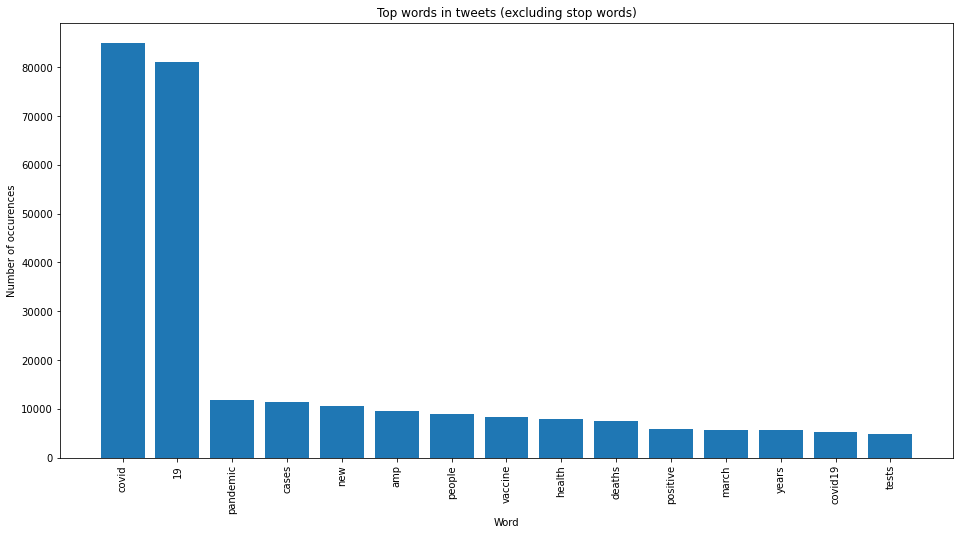

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in tweets (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [204]:
#Convert the sentences to words using gensim utils
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(df['clean_text']))
import pprint
pp = pprint.PrettyPrinter()
for i, row in enumerate(data_words):
    print(row)
    if i> 10:
        break

['agreed', 'why', 'do', 'people', 'keep', 'on', 'supporting', 'democrats', 'from', 'the', 'covid', 'lies', 'to', 'the', 'fake', 'climate', 'crisis', 'to', 'the', 'fake', 'jan', 'th', 'insurrection', 'to', 'the', 'fake', 'inflation', 'caused', 'by', 'greedy', 'corporations', 'to', 'the']
['ad', 'ihealth', 'covid', 'antigen', 'testing', 'kits', 'for', 'sale']
['study', 'links', 'even', 'mild', 'covid', 'to', 'changes', 'in', 'the', 'brain', 'cnn']
['non', 'death', 'on', 'top', 'of', 'all', 'the', 'deaths', 'march', 'hkt']
['sfc', 'urges', 'hong', 'kong', 'businesses', 'to', 'update', 'continuity', 'plans', 'as', 'mass', 'covid', 'testing', 'looms', 'in', 'the', 'city']
['you', 've', 'taken', 'few', 'too', 'many', 'hits', 'on', 'the', 'crack', 'pipe', 'our', 'natural', 'immunity', 'works', 'better', 'than', 'any', 'vaccine', 'my', 'whole', 'family', 'had', 'covid', 'not', 'hospitalized', 'we', 'are', 'healthy', 'people', 'no', 'vaccine', 'required', 'god', 'bless']
['look', 'at', 'covid',

In [153]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [154]:
#Build the bigram and trigram models
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [155]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [203]:
#Display the Trigrams built
for i, row in enumerate(data_words_trigrams):
    print(row)
    if i > 20:
        break

['agreed', 'people', 'keep', 'supporting', 'democrats', 'covid', 'lies', 'fake', 'climate', 'crisis', 'fake', 'jan', 'th', 'insurrection', 'fake', 'inflation', 'caused', 'greedy', 'corporations']
['ad_ihealth', 'covid', 'antigen', 'testing', 'kits', 'sale']
['study_links', 'even_mild', 'covid', 'changes', 'brain', 'cnn']
['non', 'death', 'top', 'deaths', 'march', 'hkt']
['sfc_urges', 'update', 'mass', 'covid', 'testing', 'looms', 'city']
['taken', 'many', 'hits', 'crack', 'pipe', 'works', 'better', 'vaccine', 'whole', 'family', 'covid', 'hospitalized', 'healthy', 'people', 'vaccine', 'required', 'god_bless']
['look', 'covid', 'medical', 'waste', 'handle']
['information', 'platforms', 'major', 'sources', 'covid', 'misinformation', 'including', 'engaged', 'sale', 'unproven', 'covid', 'products', 'services', 'treatments', 'lol', 'would']
['uncontrolled', 'spread', 'lead', 'creation', 'worse', 'variant', 'us', 'seems', 'setting', 'perfect', 'conditions', 'worse', 'variant', 'harm', 'countr

In [157]:
# Form Bigrams and Trigrams
#data_words_bigrams = make_bigrams(data_words_nostops)
data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(data_words_bigrams)
data_words_trigrams[10:20]
#Remove the stop words
data_words_nostops = remove_stopwords(data_words_trigrams) 
data_words_trigrams = data_words_nostops
#data_words_nostops[0:20]

In [202]:
#Display the Trigrams built after stop words removal
for i, row in enumerate(data_words_nostops):
    print(row)
    if i > 20:
        break

['agreed', 'people', 'keep', 'supporting', 'democrats', 'covid', 'lies', 'fake', 'climate', 'crisis', 'fake', 'jan', 'th', 'insurrection', 'fake', 'inflation', 'caused', 'greedy', 'corporations']
['ad_ihealth', 'covid', 'antigen', 'testing', 'kits', 'sale']
['study_links', 'even_mild', 'covid', 'changes', 'brain', 'cnn']
['non', 'death', 'top', 'deaths', 'march', 'hkt']
['sfc_urges', 'update', 'mass', 'covid', 'testing', 'looms', 'city']
['taken', 'many', 'hits', 'crack', 'pipe', 'works', 'better', 'vaccine', 'whole', 'family', 'covid', 'hospitalized', 'healthy', 'people', 'vaccine', 'required', 'god_bless']
['look', 'covid', 'medical', 'waste', 'handle']
['information', 'platforms', 'major', 'sources', 'covid', 'misinformation', 'including', 'engaged', 'sale', 'unproven', 'covid', 'products', 'services', 'treatments', 'lol', 'would']
['uncontrolled', 'spread', 'lead', 'creation', 'worse', 'variant', 'us', 'seems', 'setting', 'perfect', 'conditions', 'worse', 'variant', 'harm', 'countr

In [159]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#data_lemmatized = lemmatization(data_words_trigrams)


In [201]:
#Display the lemmatized data
for i, row in enumerate(data_lemmatized):
    print(row)
    if i > 20:
        break

['agree', 'people', 'keep', 'support', 'democrats', 'covid', 'lie', 'fake', 'climate', 'crisis', 'fake', 'jan', 'th', 'insurrection', 'fake', 'inflation', 'cause', 'greedy', 'corporation']
['ad_ihealth', 'covid', 'antigen', 'testing', 'kit', 'sale']
['study_link', 'even_mild', 'covid', 'change', 'brain', 'cnn']
['non', 'death', 'top', 'death', 'march', 'hkt']
['sfc_urge', 'update', 'mass', 'covid', 'testing', 'loom', 'city']
['take', 'many', 'hit', 'crack', 'pipe', 'work', 'well', 'vaccine', 'whole', 'family', 'covid', 'hospitalize', 'healthy', 'people', 'vaccine', 'require', 'god_bless']
['look', 'covid', 'medical', 'waste', 'handle']
['information', 'platform', 'major', 'source', 'covid', 'misinformation', 'include', 'engage', 'sale', 'unproven', 'covid', 'product', 'service', 'treatment', 'lol', 'would']
['uncontrolled', 'spread', 'lead', 'creation', 'bad', 'variant', 'we', 'seem', 'set', 'perfect', 'condition', 'bad', 'variant', 'harm', 'country', 'harm', 'world', 'shameful', 'even

In [162]:
l2 = []
for items in data_lemmatized:
    temp = [item for item in items if len(item) >= 3]
    l2.append(temp)
data_lemmatized02 = l2
len(data_lemmatized02)


105000

In [205]:
#Display the final clean data after removing words < 3 in length
for i, row in enumerate(data_lemmatized02):
    print(row)
    if i > 20:
        break

['agree', 'people', 'keep', 'support', 'democrats', 'covid', 'lie', 'fake', 'climate', 'crisis', 'fake', 'jan', 'insurrection', 'fake', 'inflation', 'cause', 'greedy', 'corporation']
['ad_ihealth', 'covid', 'antigen', 'testing', 'kit', 'sale']
['study_link', 'even_mild', 'covid', 'change', 'brain', 'cnn']
['non', 'death', 'top', 'death', 'march', 'hkt']
['sfc_urge', 'update', 'mass', 'covid', 'testing', 'loom', 'city']
['take', 'many', 'hit', 'crack', 'pipe', 'work', 'well', 'vaccine', 'whole', 'family', 'covid', 'hospitalize', 'healthy', 'people', 'vaccine', 'require', 'god_bless']
['look', 'covid', 'medical', 'waste', 'handle']
['information', 'platform', 'major', 'source', 'covid', 'misinformation', 'include', 'engage', 'sale', 'unproven', 'covid', 'product', 'service', 'treatment', 'lol', 'would']
['uncontrolled', 'spread', 'lead', 'creation', 'bad', 'variant', 'seem', 'set', 'perfect', 'condition', 'bad', 'variant', 'harm', 'country', 'harm', 'world', 'shameful', 'even', 'take', '

In [164]:
# Create Dictionary

id2word = corpora.Dictionary(data_lemmatized02)

# Create Corpus
texts = data_lemmatized02

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


In [200]:
print(corpus[0:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


In [166]:
# Display of corpus (term-frequency)u
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('agree', 1),
  ('cause', 1),
  ('climate', 1),
  ('corporation', 1),
  ('covid', 1),
  ('crisis', 1),
  ('democrats', 1),
  ('fake', 3),
  ('greedy', 1),
  ('inflation', 1),
  ('insurrection', 1),
  ('jan', 1),
  ('keep', 1),
  ('lie', 1),
  ('people', 1),
  ('support', 1)],
 [('covid', 1),
  ('ad_ihealth', 1),
  ('antigen', 1),
  ('kit', 1),
  ('sale', 1),
  ('testing', 1)],
 [('covid', 1),
  ('brain', 1),
  ('change', 1),
  ('cnn', 1),
  ('even_mild', 1),
  ('study_link', 1)],
 [('death', 2), ('hkt', 1), ('march', 1), ('non', 1), ('top', 1)],
 [('covid', 1),
  ('testing', 1),
  ('city', 1),
  ('loom', 1),
  ('mass', 1),
  ('sfc_urge', 1),
  ('update', 1)]]

In [167]:
# Build LDA model with 15 topics first
k = 15
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
#                                            update_every=1,
                                           chunksize=10000,
                                            passes=50,
                                            iterations = 50,
                                           alpha=.001)

In [168]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.077*"covid" + 0.030*"restriction" + 0.021*"health" + 0.019*"say" + '
  '0.018*"lift" + 0.015*"public" + 0.014*"mask_mandate" + 0.013*"end" + '
  '0.011*"mandate" + 0.010*"measure"'),
 (1,
  '0.072*"covid" + 0.026*"study" + 0.021*"new" + 0.021*"infection" + '
  '0.017*"case" + 0.014*"china" + 0.014*"risk" + 0.014*"variant" + '
  '0.013*"brain" + 0.012*"omicron"'),
 (2,
  '0.053*"die" + 0.051*"covid" + 0.039*"people" + 0.037*"million" + '
  '0.023*"life" + 0.021*"death" + 0.020*"americans" + 0.018*"kill" + '
  '0.016*"many" + 0.016*"pandemic"'),
 (3,
  '0.088*"covid" + 0.075*"case" + 0.050*"death" + 0.042*"new" + 0.035*"report" '
  '+ 0.019*"update" + 0.015*"march" + 0.014*"total" + 0.013*"number" + '
  '0.011*"daily"'),
 (4,
  '0.083*"covid" + 0.035*"dose" + 0.028*"datum" + 0.025*"death" + '
  '0.016*"vaccination" + 0.016*"case" + 0.015*"current_stat" + 0.010*"show" + '
  '0.007*"administer" + 0.007*"vaccine"'),
 (5,
  '0.033*"covid" + 0.027*"amp" + 0.012*"pandemic" + 0.011*"p

In [169]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized02, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.078994434360524

Coherence Score:  0.4874729225283338


In [90]:
#Method to build multiple models and calculate the cohernce for each
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
#     coherence_values_umass = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
#                                            update_every=1,
                                           chunksize=10000,
                                           passes=50,
                                           iterations = 50,
                                           alpha=.001)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [91]:
# Build the models starting from 5 topics to 26 topics in steps of 5
model_list = []
coherence_values =[]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized02, start=5, limit=26, step=5)

In [93]:
coherence_values


[0.4231921411900272,
 0.45467490471574157,
 0.4939663027091351,
 0.4812322854393156,
 0.4868902214516999]

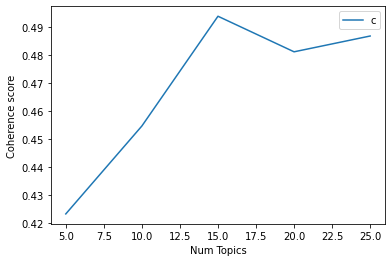

In [94]:
# Graph the coherence values
limit=26; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [95]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4232
Num Topics = 10  has Coherence Value of 0.4547
Num Topics = 15  has Coherence Value of 0.494
Num Topics = 20  has Coherence Value of 0.4812
Num Topics = 25  has Coherence Value of 0.4869


In [96]:
# Select the model with the highest coherence and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.076*"covid" + 0.030*"restriction" + 0.022*"health" + 0.019*"say" + '
  '0.018*"lift" + 0.016*"public" + 0.014*"end" + 0.014*"mask_mandate" + '
  '0.011*"mandate" + 0.010*"measure"'),
 (1,
  '0.072*"covid" + 0.025*"study" + 0.021*"new" + 0.021*"infection" + '
  '0.017*"case" + 0.015*"china" + 0.014*"risk" + 0.014*"variant" + '
  '0.013*"brain" + 0.012*"omicron"'),
 (2,
  '0.052*"die" + 0.050*"covid" + 0.038*"people" + 0.036*"million" + '
  '0.024*"life" + 0.020*"death" + 0.019*"americans" + 0.019*"kill" + '
  '0.016*"many" + 0.016*"pandemic"'),
 (3,
  '0.088*"covid" + 0.075*"case" + 0.050*"death" + 0.042*"new" + 0.035*"report" '
  '+ 0.019*"update" + 0.015*"march" + 0.014*"total" + 0.013*"number" + '
  '0.011*"day"'),
 (4,
  '0.082*"covid" + 0.034*"dose" + 0.029*"datum" + 0.026*"death" + 0.016*"case" '
  '+ 0.016*"current_stat" + 0.015*"vaccination" + 0.010*"show" + '
  '0.007*"administer" + 0.006*"vaccine"'),
 (5,
  '0.033*"covid" + 0.026*"amp" + 0.012*"pandemic" + 0.011*"peo

In [97]:
# Visualize the topics using the optimal model
pyLDAvis.enable_notebook()
vis = gm.prepare(optimal_model, corpus, id2word)
vis

C:\Users\balam\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.169677  0.004413       1        1  11.825478
3      0.227035  0.158800       2        1  10.641088
5     -0.194036  0.015385       3        1   9.580582
10     0.061224 -0.178739       4        1   7.649470
6     -0.047667  0.014862       5        1   7.423925
11    -0.162961  0.071016       6        1   7.347763
8     -0.023921 -0.038182       7        1   6.409038
1      0.080466  0.191388       8        1   6.364306
12     0.063517 -0.070820       9        1   6.173958
13     0.005535 -0.151193      10        1   5.372602
0      0.035303 -0.067180      11        1   5.359006
14    -0.059008 -0.063748      12        1   5.013223
7      0.067549 -0.079913      13        1   4.320541
2     -0.103880  0.181339      14        1   3.549753
4      0.220522  0.012573      15        1   2.969267, topic_info=          Term          Freq         Total Category  logprob  loglift
102       test   8718.000000   8718.000000  Default  30.0000  30.0000
46     vaccine  12017.000000  12017.000000  Default  29.0000  29.0000
212       case  12533.000000  12533.000000  Default  28.0000  28.0000
891   positive   6563.000000   6563.000000  Default  27.0000  27.0000
246       year   8063.000000   8063.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
211    science    138.775418    857.652674  Topic15  -5.6402   1.6955
695  vaccinate    151.833208   1567.660907  Topic15  -5.5503   1.1823
115        amp    164.545480   9319.185103  Topic15  -5.4699  -0.5198
456        new    150.719478  10317.353610  Topic15  -5.5577  -0.7093
230        due    118.560252   2874.632432  Topic15  -5.7977   0.3286

[1136 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1163      3  0.125285  access
1163      4  0.314604  access
1163      7  0.393952  access
1163      8  0.002784  access
1163      9  0.150342  access
...     ...       ...     ...
310       8  0.042306     yes
310       9  0.032153     yes
310      11  0.003384     yes
310      14  0.045691     yes
2541      1  0.973032  yr_old

[3478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 6, 11, 7, 12, 9, 2, 13, 14, 1, 15, 8, 3, 5])

In [98]:
#Assign a Dominant topic to each of the documents in the corpus.
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [125]:
#res = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['text'])
res

,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,11,0.5456,"covid, ukraine, war, world, russia, china, like, trump, putin, lab","@MaryLTrump @DavidCornDC Agreed, why do people keep on supporting Democrats??? From the COVID-19 lies to the fake climate crisis to the fake Jan 6th insurrection to the fake inflation caused by greedy corporations to the …"
1,7,0.8173,"test, covid, positive, home, free, order, obama, say, symptom, negative",AD iHealth™ Covid-19 Antigen testing kits for sale https://t.co/4BMuYxmuH5
2,1,0.9977,"covid, study, new, infection, case, china, risk, variant, brain, omicron",Study links even mild Covid-19 to changes in the brain - CNN #DemForce https://t.co/diPFToBDv6
3,3,0.8239,"covid, case, death, new, report, update, march, total, number, day",",...a NON-#covid19 death ON TOP OF ALL the #covid19 deaths (March 7, 2022; 22:17 HKT) #HONGKONG #HK"
4,0,0.4599,"covid, restriction, health, say, lift, public, end, mask_mandate, mandate, measure",SFC urges Hong Kong businesses to update continuity plans as mass Covid-19 testing looms in the city https://t.co/bcx5kVFP3t
...,...,...,...,...
104995,9,0.7381,"covid, get, people, mask, still, know, say, like, wear, need",What do you think about the 4th wave of covid-19 in India?\n\nKnow more: https://t.co/jDqGkNnzMY\n\n#4th_wave_in_India #4th_wave_of_covid_in_india #4th_covid_wave #Covid_case_in_India https://t.co/80CgE5tpgf
104996,4,0.7730,"covid, dose, datum, death, case, current_stat, vaccination, show, administer, vaccine","Cervical longitudinally extensive myelitis after #CovidVaccination: \nhttps://t.co/dcXxoaid5Z\n""In summary, we emphasize again that the clinicians should be aware of the possibility of development of LTEM after different COVID-19 vaccines.""\n#VaccineSideEffects #COVID19"
104997,12,0.5807,"vaccine, covid, child, dose, pfizer, kid, florida, vaccination, via, get",📢 Austria suspends mandatory Covid-19 vaccinations for all adults citing the pandemic no longer posses the same danger.
104998,11,0.7407,"covid, ukraine, war, world, russia, china, like, trump, putin, lab","@JohnSty83584062 God forbid that any site should want to prevent Russian misinformation being spread!\n\nIt's rather interesting that so many who instantly made accusations of ""Russian bot"" at those who didn't agree with them about Trump, Corbyn, Brexit and Covid-19 now believing Russia."


In [92]:
df3 = pd.DataFrame(columns = ['clean_text'])
df4 = pd.DataFrame()
for i, row in enumerate(data_lemmatized02):
    temp = ""
    for item in row:
        temp = temp + " " + item
    df3.at[i] = temp
    
df4['clean_text'] = df3    
#Store the output for further sentiment analysis
df4.to_csv("SentimentTweets01_cleantxt.csv", encoding = "utf-8-sig", sep = ",", index = False)

In [100]:
#Store the output for further sentiment analysis
res.to_csv("SentimentTweets01.csv", encoding = "utf-8-sig", sep = ",", index = False)

<AxesSubplot:xlabel='Dominant_Topic'>

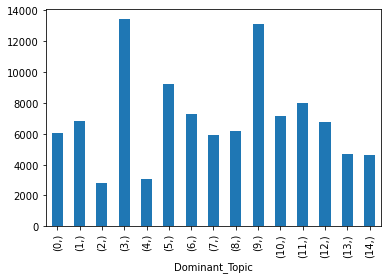

In [101]:
#Plot the count of topics in each Dominant Topic
out1 = res.value_counts(subset=['Dominant_Topic'], sort=False)
out1.plot.bar()
